<a href="https://colab.research.google.com/github/nisal435/Automatic-Summarization-using-Deep-Learning/blob/main/Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Environment Setup**

In [1]:
!pip install optuna
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates # Import mdates

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import IsolationForest, RandomForestRegressor

# Models
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Explainability & Optimization (optional)
import shap
import optuna

# Reproducibility
np.random.seed(42)

**2. Data Loading & EDA**

In [2]:
def load_data(filepath):
    """
    Load and preprocess data capacity growth dataset
    """
    data = pd.read_csv(filepath)  # Load without parsing dates initially
    print("Columns in the dataset:", data.columns.tolist()) # Display column names

    # Assuming the user will provide the correct column name after seeing the output
    # data = pd.read_csv(filepath, parse_dates=['YourCorrectDatetimeColumn']) # Uncomment and modify after identifying the column

    data = data.sort_values(data.columns[0]).reset_index(drop=True) # Sort by the first column temporarily

    # Clean column names
    data.columns = data.columns.str.strip()

    # Define numeric columns to convert, e.g., Data Volume, Capacity
    numeric_cols = ['Data_Volume']  # Replace with your numeric columns

    # Clean numeric columns if needed (remove commas etc)
    for col in numeric_cols:
        if col in data.columns: # Check if column exists
            data[col] = data[col].astype(str).str.replace(',', '').str.strip()
            data[col] = pd.to_numeric(data[col], errors='coerce')

    # Drop rows with missing values in numeric columns
    data = data.dropna(subset=[col for col in numeric_cols if col in data.columns]) # Drop if column exists and has NaNs

    return data

# Load your dataset
dataset = '/content/3. modified_dataset.csv'  # Replace with your dataset path
data = load_data(dataset)
display(data.head())

Columns in the dataset: ['Date', 'Schema_A', 'Schema_B', 'Schema_C', 'data_volume', 'holiday', 'week_num_of_the_month', 'day_of_the_week']


,Date,Schema_A,Schema_B,Schema_C,data_volume,holiday,week_num_of_the_month,day_of_the_week
0,2023-01-01,40807245,83314629,18510227,145465162,no,1,Saturday
1,2023-01-02,32693382,70206393,18352530,123501437,no,1,Sunday
2,2023-01-03,34080546,71780435,18379816,125772180,no,1,Monday
3,2023-01-04,33041255,71462943,18394799,124472875,no,1,Tuesday
4,2023-01-05,32754259,70365947,18381909,122871899,no,1,Wednesday


In [3]:
# Basic info
print(f"Dataset shape: {data.shape}")

Dataset shape: (730, 8)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Date                   730 non-null    object
 1   Schema_A               730 non-null    int64 
 2   Schema_B               730 non-null    int64 
 3   Schema_C               730 non-null    int64 
 4   data_volume            730 non-null    int64 
 5   holiday                730 non-null    object
 6   week_num_of_the_month  730 non-null    int64 
 7   day_of_the_week        730 non-null    object
dtypes: int64(5), object(3)
memory usage: 45.8+ KB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Schema_A,730.0,1.292149e+08,1.210211e+08,23177483.0,5.561978e+07,80783245.0,2.088504e+08,9.603817e+08
Schema_B,730.0,1.647041e+08,8.926675e+07,67271758.0,8.639025e+07,152951482.0,2.179032e+08,3.667076e+08
Schema_C,730.0,1.815734e+07,2.080862e+06,6429362.0,1.677785e+07,17469107.0,1.888396e+07,2.228846e+07
data_volume,730.0,3.140531e+08,2.018943e+08,119638229.0,1.545860e+08,276055193.0,4.435043e+08,1.351164e+09
week_num_of_the_month,730.0,2.830137e+00,1.293084e+00,1.0,2.000000e+00,3.0,4.000000e+00,5.000000e+00


In [6]:
print("Data types:")
print(data.dtypes)

Data types:
Date                     object
Schema_A                  int64
Schema_B                  int64
Schema_C                  int64
data_volume               int64
holiday                  object
week_num_of_the_month     int64
day_of_the_week          object
dtype: object


In [7]:
print("Missing values:")
print(data.isnull().sum())

Missing values:
Date                     0
Schema_A                 0
Schema_B                 0
Schema_C                 0
data_volume              0
holiday                  0
week_num_of_the_month    0
day_of_the_week          0
dtype: int64


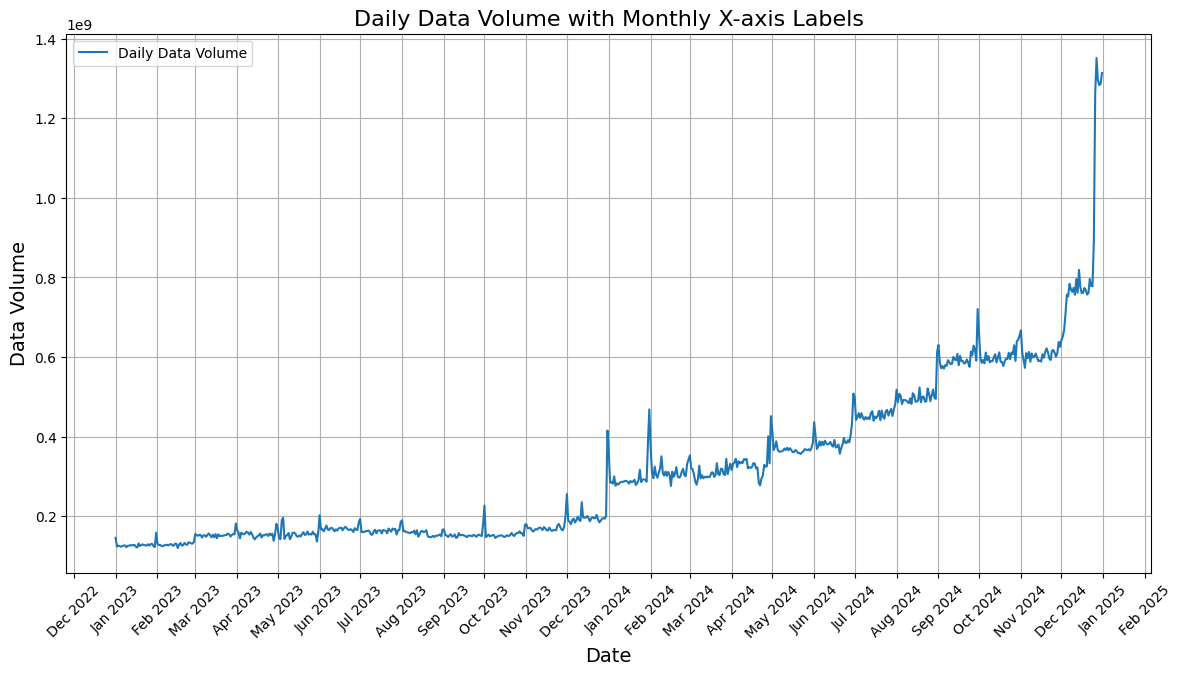

In [8]:
# Convert 'Date' column to datetime objects
data['Date'] = pd.to_datetime(data['Date'])

plt.figure(figsize=(14,7))
plt.plot(data['Date'], data['data_volume'], label='Daily Data Volume')

# Set major ticks format to show Month-Year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())   # Tick every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format like 'Jan 2023'

plt.title('Daily Data Volume with Monthly X-axis Labels', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Data Volume', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

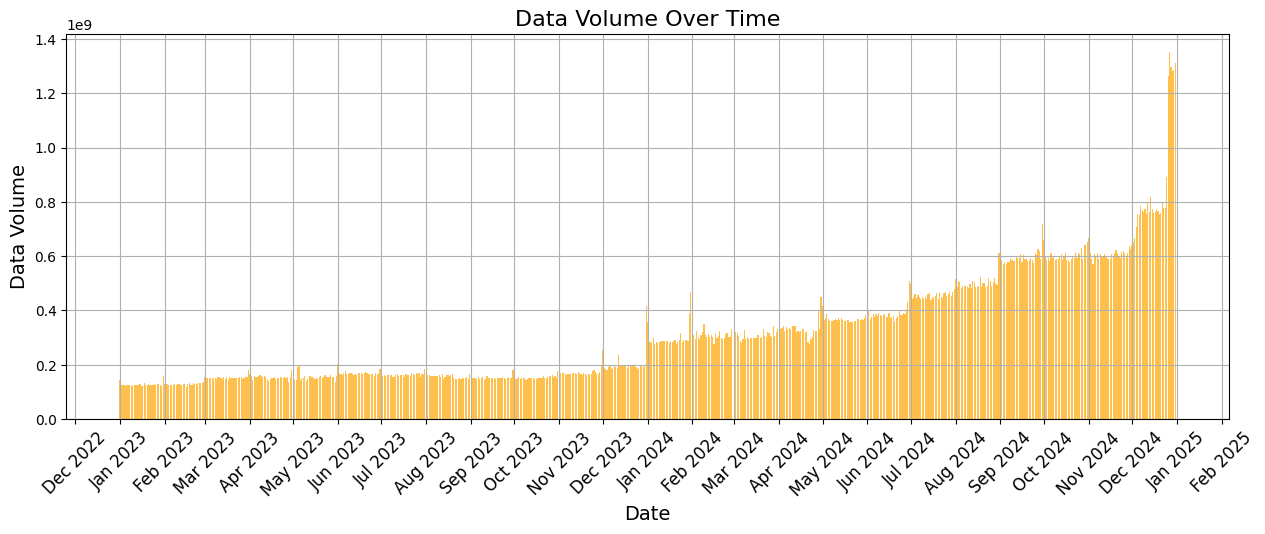

In [9]:
plt.figure(figsize=(15, 5))
plt.bar(data['Date'], data['data_volume'], color='orange', alpha=0.7)

plt.title('Data Volume Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Data Volume', fontsize=14)

# Format x-axis to show months only
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(fontsize=12, rotation=45)
plt.grid(True)

plt.show()

**3. Data Preprocessing**

In [10]:
from sklearn.ensemble import IsolationForest

def remove_outliers(data):
    """
    Detect and remove outliers using Isolation Forest on relevant numeric columns
    """
    # Choose numeric columns relevant for outlier detection
    numeric_cols = ['Schema_A', 'Schema_B', 'Schema_C', 'data_volume']

    # Fit Isolation Forest on these columns
    iso_forest = IsolationForest(contamination=0.01, random_state=42)
    outliers = iso_forest.fit_predict(data[numeric_cols])

    # Keep only non-outliers (label = 1)
    clean_data = data[outliers == 1].reset_index(drop=True)
    return clean_data

data = remove_outliers(data)
print(f"Data shape after outlier removal: {data.shape}")

original_count = data.shape[0]
data = remove_outliers(data)
removed_count = original_count - data.shape[0]
print(f"Outliers removed: {removed_count}")


Data shape after outlier removal: (722, 8)
Outliers removed: 8


In [11]:
def create_features(data):
    """
    Create features for data volume forecasting
    """
    # Example: volume range (max-min) among schemas
    data['Schema_Range'] = data[['Schema_A', 'Schema_B', 'Schema_C']].max(axis=1) - data[['Schema_A', 'Schema_B', 'Schema_C']].min(axis=1)

    # Percentage change of data_volume (like return)
    data['Volume_Change'] = data['data_volume'].pct_change()

    # Rolling means of data_volume to capture trends
    data['Volume_MA_3'] = data['data_volume'].rolling(window=3).mean()
    data['Volume_MA_7'] = data['data_volume'].rolling(window=7).mean()
    data['Volume_MA_14'] = data['data_volume'].rolling(window=14).mean()

    # Rolling std (volatility) of data_volume
    data['Volume_Volatility_7'] = data['data_volume'].rolling(window=7).std()
    data['Volume_Volatility_14'] = data['data_volume'].rolling(window=14).std()

    # Momentum-like feature: difference over 3 and 7 days
    data['Momentum_3'] = data['data_volume'].diff(3)
    data['Momentum_7'] = data['data_volume'].diff(7)

    # Drop NA values created by rolling calculations
    data = data.dropna().reset_index(drop=True)

    return data

data = create_features(data)
print(f"Dataset after feature engineering: {data.shape}")
display(data.tail())


Dataset after feature engineering: (701, 17)


,Date,Schema_A,Schema_B,Schema_C,data_volume,holiday,week_num_of_the_month,day_of_the_week,Schema_Range,Volume_Change,Volume_MA_3,Volume_MA_7,Volume_MA_14,Volume_Volatility_7,Volume_Volatility_14,Momentum_3,Momentum_7
696,2024-12-19,406823237,337048356,22121162,767911448,no,3,Tuesday,384702075,-0.006749,7.673732e+08,7.739600e+08,7.568713e+08,2.060472e+07,4.442476e+07,7348163.0,-27738618.0
697,2024-12-20,395136192,337518084,22146637,756736338,no,3,Wednesday,372989555,-0.014553,7.659256e+08,7.733052e+08,7.644083e+08,2.113924e+07,3.246109e+07,-4342829.0,-4583443.0
698,2024-12-21,398717142,337541787,22182084,760681365,no,4,Thursday,376535058,0.005213,7.617764e+08,7.650134e+08,7.710266e+08,7.028735e+06,1.711812e+07,-12447743.0,-58042701.0
699,2024-12-23,406060407,347215342,22173722,778348609,no,4,Saturday,383886685,0.023226,7.652554e+08,7.654928e+08,7.715976e+08,7.885014e+06,1.722696e+07,10437161.0,3355366.0
700,2024-12-24,405203559,347555088,22163269,777538513,no,4,Sunday,383040290,-0.001041,7.721895e+08,7.679178e+08,7.726112e+08,8.685962e+06,1.712140e+07,20802175.0,16975228.0


In [12]:
def normalize_data_capacity(data):
    """
    Normalize features using MinMaxScaler for capacity growth dataset
    """
    # List of numeric features to normalize (example)
    features = ['Schema_A', 'Schema_B', 'Schema_C', 'data_volume']

    # Initialize scalers
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    feature_scaler = MinMaxScaler(feature_range=(0, 1))

    # Assuming 'data_volume' is your target variable, scale it separately
    data['data_volume_scaled'] = target_scaler.fit_transform(data[['data_volume']])

    # Scale other features except target
    data[features] = feature_scaler.fit_transform(data[features])

    return data, target_scaler, feature_scaler

data, target_scaler, feature_scaler = normalize_data_capacity(data)
print("Data after normalization:")
display(data.head())


Data after normalization:


,Date,Schema_A,Schema_B,Schema_C,data_volume,holiday,week_num_of_the_month,day_of_the_week,Schema_Range,Volume_Change,Volume_MA_3,Volume_MA_7,Volume_MA_14,Volume_Volatility_7,Volume_Volatility_14,Momentum_3,Momentum_7,data_volume_scaled
0,2023-01-14,0.025642,0.014798,0.763965,0.010779,yes,3,Friday,52955548,0.006602,1.268598e+08,1.256546e+08,1.265933e+08,1.793479e+06,5.646484e+06,1669410.0,1130754.0,0.010779
1,2023-01-15,0.027266,0.014130,0.765583,0.011488,no,3,Saturday,52742881,0.003899,1.270608e+08,1.258588e+08,1.253222e+08,1.946133e+06,1.684040e+06,602918.0,1429827.0,0.011488
2,2023-01-16,0.022473,0.010636,0.764169,0.004596,no,3,Sunday,51785809,-0.037740,1.258980e+08,1.259943e+08,1.252758e+08,1.632583e+06,1.745949e+06,-3488226.0,948376.0,0.004596
3,2023-01-17,0.021937,0.001648,0.761764,0.001857,yes,3,Monday,49304417,-0.015588,1.238189e+08,1.253629e+08,1.249303e+08,2.529100e+06,2.085539e+06,-6237323.0,-4419776.0,0.001857
4,2023-01-18,0.028200,0.025521,0.768482,0.016750,no,3,Tuesday,55889794,0.086090,1.250450e+08,1.261977e+08,1.254214e+08,3.398455e+06,2.691005e+06,3678254.0,5843493.0,0.016750


**4. Data Preparation for Modeling**

In [76]:
# Create sequences for LSTM
def create_sequences(data, seq_length, feature_cols, target_col):
    """
    Create input sequences and corresponding targets for time series prediction.
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq_x = data[feature_cols].iloc[i:i+seq_length].values
        target_y = data[target_col].iloc[i+seq_length]
        X.append(seq_x)
        y.append(target_y)
    return np.array(X), np.array(y)

# Data augmentation with jittering
def jitter(X, noise_factor=0.01):
    """
    Add small Gaussian noise to sequences for augmentation.
    """
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=X.shape)
    return X + noise

# Parameters
SEQ_LENGTH = 10
TEST_SIZE = 0.2

# Feature and target columns
feature_columns = [
    'Schema_A', 'Schema_B', 'Schema_C', 'Schema_Range',
    'Volume_Change', 'Volume_MA_3', 'Volume_MA_7', 'Volume_MA_14',
    'Volume_Volatility_7', 'Volume_Volatility_14',
    'Momentum_3', 'Momentum_7'
]
target_column = 'data_volume_scaled'

# Create sequences
X, y = create_sequences(data, SEQ_LENGTH, feature_columns, target_column)

# Optional: Data augmentation
X_augmented = jitter(X, noise_factor=0.01)
X = np.concatenate([X, X_augmented], axis=0)
y = np.concatenate([y, y], axis=0)

# Time-aware train-test split
split_index = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Output shapes
print(f"Final dataset shape after augmentation: X = {X.shape}, y = {y.shape}")
print(f"Training set shape: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Test set shape: X_test = {X_test.shape}, y_test = {y_test.shape}")

Final dataset shape after augmentation: X = (1382, 10, 12), y = (1382,)
Training set shape: X_train = (1105, 10, 12), y_train = (1105,)
Test set shape: X_test = (277, 10, 12), y_test = (277,)


In [14]:
def train_test_split_time_series(X, y, test_size=0.2):
    """
    Split sequences into training and testing sets while preserving time order.

    Args:
        X (np.array): Input sequences.
        y (np.array): Target values.
        test_size (float): Fraction of data reserved for testing.

    Returns:
        X_train, X_test, y_train, y_test (np.arrays)
    """
    split_idx = int(len(X) * (1 - test_size))

    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = train_test_split_time_series(X, y, TEST_SIZE)

print(f"Training set: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Testing set: X_test = {X_test.shape}, y_test = {y_test.shape}")

Training set: X_train = (1105, 10, 12), y_train = (1105,)
Testing set: X_test = (277, 10, 12), y_test = (277,)


**5. Model Building**

In [15]:
def build_lstm_model(input_shape, lstm_units=64, dense_units=32, dropout_rate=0.3, learning_rate=0.0003):
    """
    Build and compile LSTM model for data capacity forecasting.

    Args:
        input_shape (tuple): Shape of the input sequence (timesteps, features).
        lstm_units (int): Number of units in LSTM layers.
        dense_units (int): Number of units in dense layer.
        dropout_rate (float): Dropout rate to reduce overfitting.
        learning_rate (float): Learning rate for Adam optimizer.

    Returns:
        Compiled Keras model.
    """
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

# Adjust input shape to your data:
input_shape = (SEQ_LENGTH, X_train.shape[2])  # e.g. (10, number_of_features)

# Build your model
lstm_model = build_lstm_model(input_shape)

lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,217 (129.75 KB)

 Trainable params: 33,217 (129.75 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# XGBoost Model
def build_xgboost_model(n_estimators=100, max_depth=5, learning_rate=0.1):
    """
    Build XGBoost model
    """
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=42
    )
    return model

# Prepare data for XGBoost (flatten sequences)
xgb_X_train = X_train.reshape(X_train.shape[0], -1)
xgb_X_test = X_test.reshape(X_test.shape[0], -1)

# Initialize XGBoost model
xgb_model = build_xgboost_model()

In [17]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest Model
def build_random_forest_model(n_estimators=100, max_depth=None, random_state=42):
    """
    Build Random Forest Regressor model
    """
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state,
        n_jobs=-1
    )
    return model

# Prepare data for Random Forest (flatten sequences)
rf_X_train = X_train.reshape(X_train.shape[0], -1)
rf_X_test = X_test.reshape(X_test.shape[0], -1)

# Initialize Random Forest model
rf_model = build_random_forest_model()

**6. Model Training**

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model.keras', save_best_only=True)

history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 114ms/step - loss: 0.2234 - mae: 0.3826 - val_loss: 0.0670 - val_mae: 0.2329
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0757 - mae: 0.2254 - val_loss: 0.0187 - val_mae: 0.1192
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0690 - mae: 0.2047 - val_loss: 0.0248 - val_mae: 0.1369
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0693 - mae: 0.2030 - val_loss: 0.0185 - val_mae: 0.1171
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0589 - mae: 0.1927 - val_loss: 0.0192 - val_mae: 0.1210
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0626 - mae: 0.1991 - val_loss: 0.0135 - val_mae: 0.0996
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0668 - mae: 0.2048 - val_loss: 0.0125 - val_mae: 0.0957
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0629 - mae: 0.2026 - val_loss: 0.0108 - val_mae: 0.0884
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - 

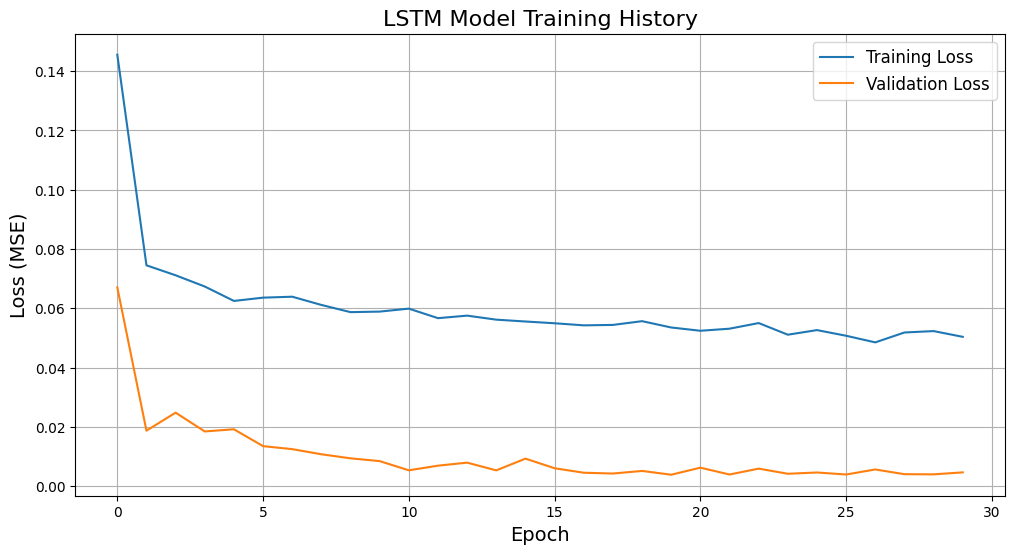

In [19]:
# Plot training history
def plot_training_history(history):
    """
    Plot training and validation loss
    """
    plt.figure(figsize=(12, 6))

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')

    plt.title('LSTM Model Training History', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss (MSE)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_training_history(history)

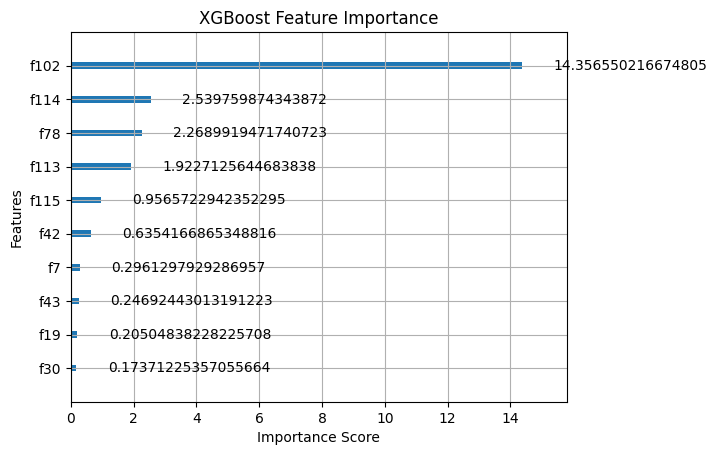

In [20]:
# Train XGBoost Model
xgb_model.fit(xgb_X_train, y_train)

# Plot feature importance
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain')
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


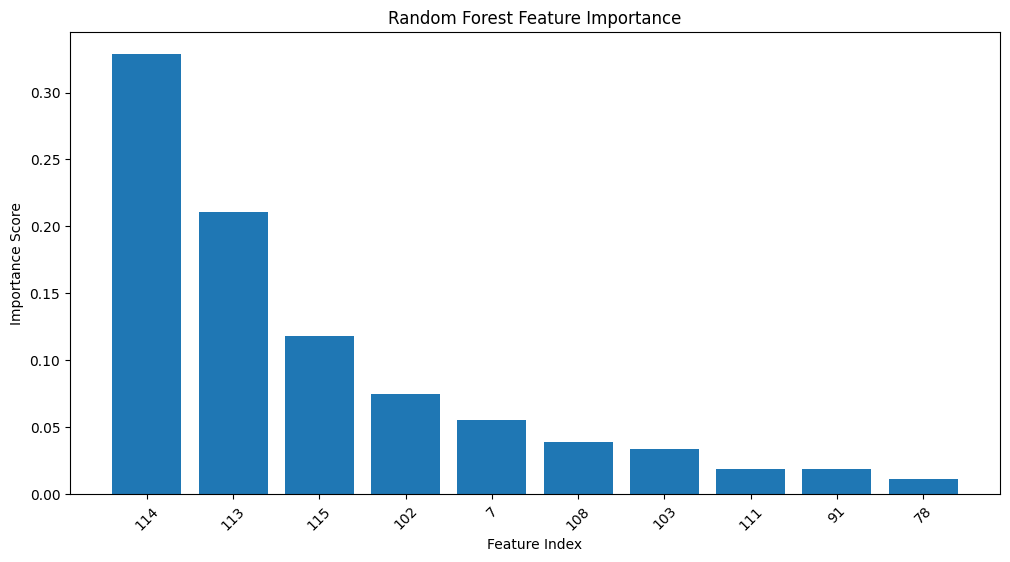

In [21]:
# Initialize Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

# Flatten sequences for Random Forest
rf_X_train = X_train.reshape(X_train.shape[0], -1)
rf_X_test = X_test.reshape(X_test.shape[0], -1)

# Train Random Forest model
rf_model.fit(rf_X_train, y_train)

# Feature importance plot
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Random Forest Feature Importance")
plt.bar(range(10), importances[indices][:10], align="center")
plt.xticks(range(10), indices[:10], rotation=45)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()

**7. Hybrid Model & Evaluation**

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict with all models
lstm_pred = lstm_model.predict(X_test).flatten()
xgb_pred = xgb_model.predict(xgb_X_test)
rf_pred = rf_model.predict(rf_X_test)

# Weighted ensemble prediction
# You can adjust weights as needed, e.g., 0.5 LSTM, 0.3 XGB, 0.2 RF
hybrid_pred = 0.1 * lstm_pred + 0.45 * xgb_pred + 0.45 * rf_pred

# Evaluation function
def evaluate_model(y_true, y_pred, model_name='Model'):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"  MSE:  {mse:.5f}")
    print(f"  MAE:  {mae:.5f}")
    print(f"  R2:   {r2:.5f}\n")
    return mse, mae, r2

# Evaluate individual models
evaluate_model(y_test, lstm_pred, 'LSTM')
evaluate_model(y_test, xgb_pred, 'XGBoost')
evaluate_model(y_test, rf_pred, 'Random Forest')

# Evaluate hybrid ensemble
evaluate_model(y_test, hybrid_pred, 'Hybrid Ensemble')

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
LSTM Performance:
  MSE:  0.12161
  MAE:  0.29532
  R2:   -2.53361

XGBoost Performance:
  MSE:  0.00038
  MAE:  0.01104
  R2:   0.98889

Random Forest Performance:
  MSE:  0.00026
  MAE:  0.01096
  R2:   0.99246

Hybrid Ensemble Performance:
  MSE:  0.00143
  MAE:  0.02996
  R2:   0.95847



(0.0014292026733216854, 0.029960039892136293, 0.9584734596151591)

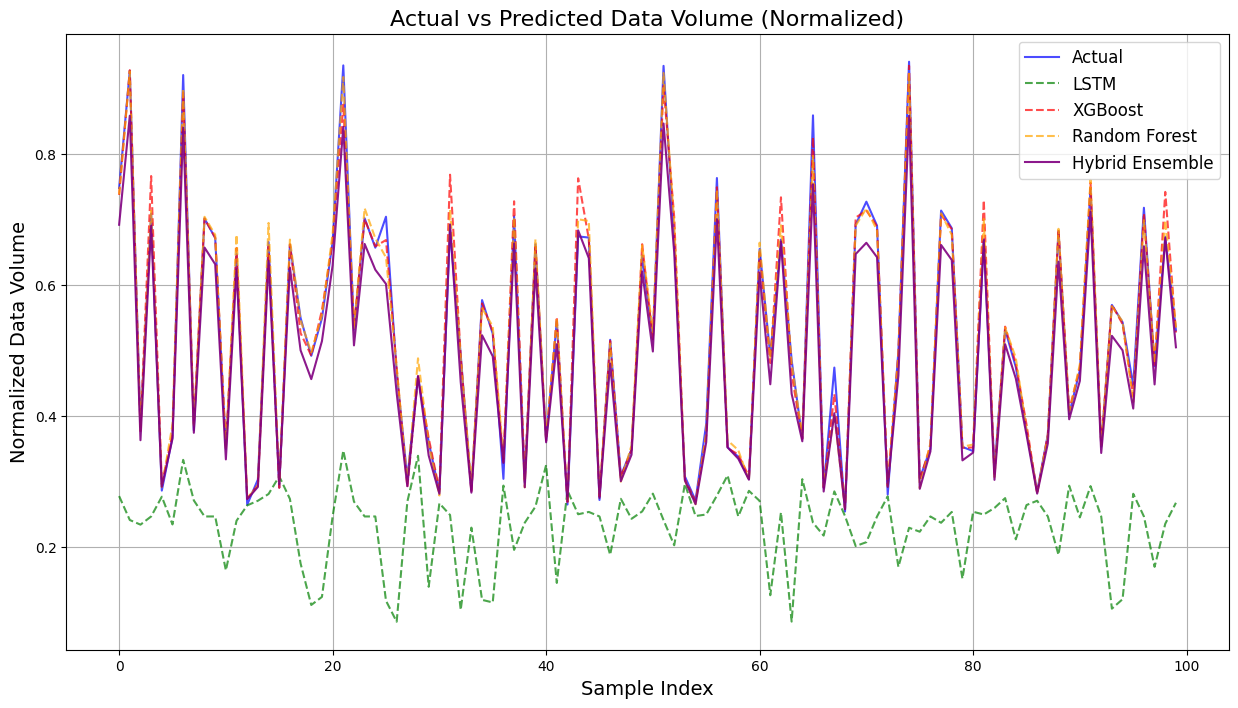

In [23]:
# Visualize predictions vs actual values
def plot_predictions(y_true, lstm_pred, xgb_pred, rf_pred, hybrid_pred, n_samples=100):
    """
    Plot actual vs predicted values for data capacity growth forecasting
    """
    plt.figure(figsize=(15, 8))

    # Select a subset of samples for clearer visualization
    idx = np.random.choice(len(y_true), size=min(n_samples, len(y_true)), replace=False)

    plt.plot(y_true[idx], label='Actual', color='blue', alpha=0.7)
    plt.plot(lstm_pred[idx], label='LSTM', color='green', linestyle='--', alpha=0.7)
    plt.plot(xgb_pred[idx], label='XGBoost', color='red', linestyle='--', alpha=0.7)
    plt.plot(rf_pred[idx], label='Random Forest', color='orange', linestyle='--', alpha=0.7)
    plt.plot(hybrid_pred[idx], label='Hybrid Ensemble', color='purple', linestyle='-', alpha=0.9)

    plt.title('Actual vs Predicted Data Volume (Normalized)', fontsize=16)
    plt.xlabel('Sample Index', fontsize=14)
    plt.ylabel('Normalized Data Volume', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# Example call (assuming you have rf_pred as Random Forest predictions)
plot_predictions(y_test, lstm_pred, xgb_pred, rf_pred, hybrid_pred)


**8. Model Explainability with SHAP**

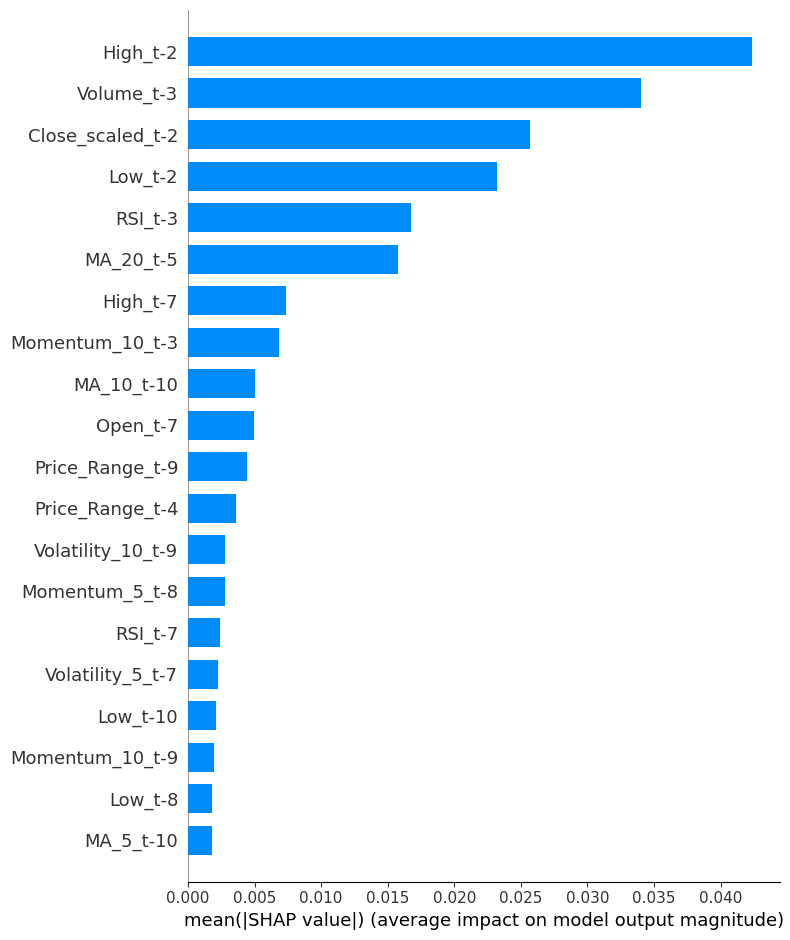

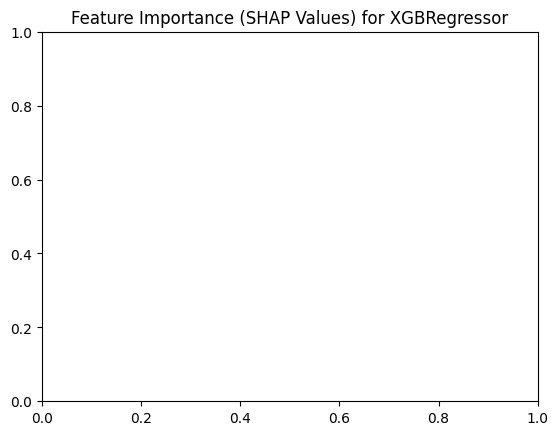

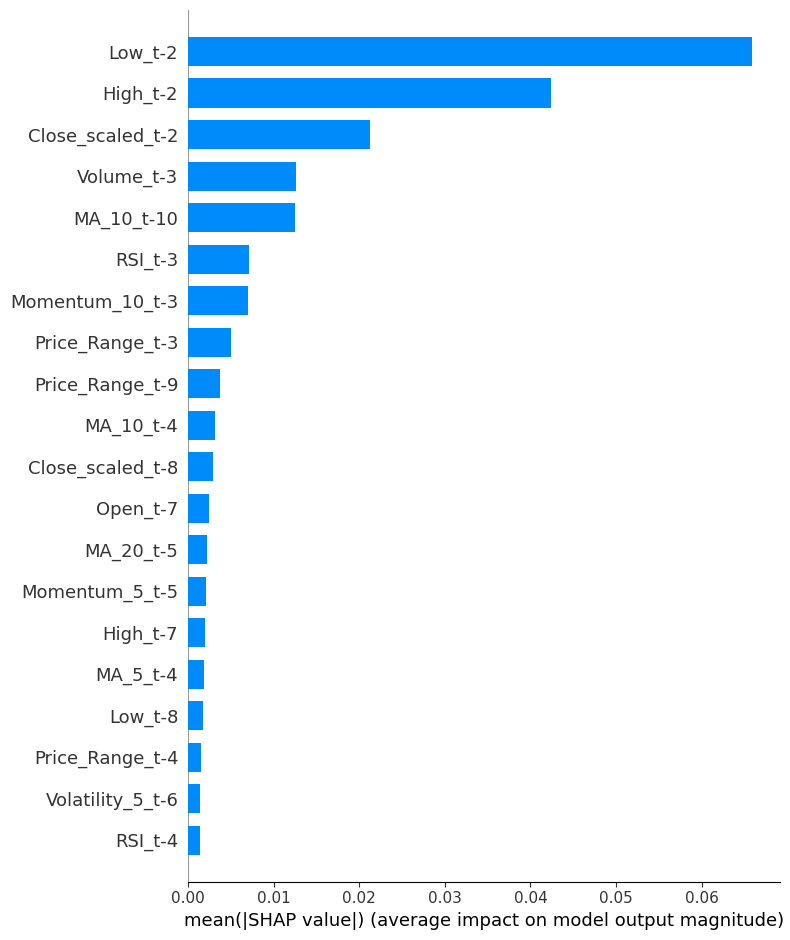

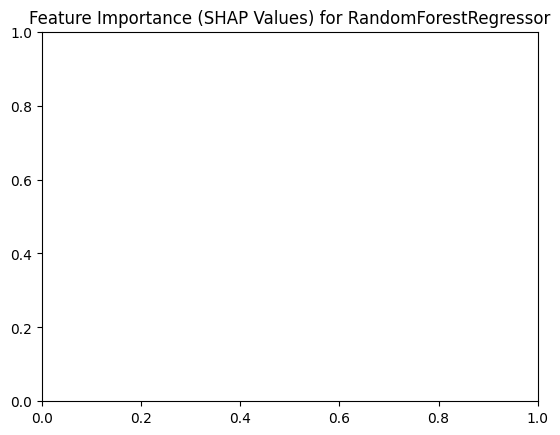

In [24]:
# SHAP Explainability function (same as yours)
def explain_model(model, X, feature_names):
    """
    Explain model predictions using SHAP values
    """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X, feature_names=feature_names, plot_type="bar")
    plt.title(f'Feature Importance (SHAP Values) for {type(model).__name__}')
    plt.show()

# Use the flattened training data for tree models
# xgb_X_train and rf_X_train must be 2D arrays with shape (samples, features)
# You already have these from data preparation step

# Feature names for flattened sequences
features = ['Open', 'High', 'Low', 'Close_scaled', 'Volume', 'Price_Range',
           'MA_5', 'MA_10', 'MA_20', 'Momentum_5', 'Momentum_10',
           'Volatility_5', 'Volatility_10', 'RSI']
feature_names = [f"{f}_t-{i}" for i in range(SEQ_LENGTH, 0, -1) for f in features]

# Explain XGBoost
explain_model(xgb_model, xgb_X_train[:1000], feature_names)

# Explain Random Forest
explain_model(rf_model, rf_X_train[:1000], feature_names)

**9. Hyperparameter Optimization with Optuna**

In [25]:
# XGBoost optimization objective
def optimize_xgboost(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'reg:squarederror',
        'random_state': 42
    }

    model = xgb.XGBRegressor(**params)
    model.fit(xgb_X_train, y_train)
    preds = model.predict(xgb_X_test)
    mse = mean_squared_error(y_test, preds)
    return mse

# Create and run study for XGBoost
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(optimize_xgboost, n_trials=50)

print("Best XGBoost trial:")
trial_xgb = study_xgb.best_trial
print(f"  MSE: {trial_xgb.value}")
print("  Params:")
for key, value in trial_xgb.params.items():
    print(f"    {key}: {value}")

# Train the optimized XGBoost model
optimized_xgb = xgb.XGBRegressor(**trial_xgb.params, random_state=42)
optimized_xgb.fit(xgb_X_train, y_train)

[I 2025-07-01 13:01:17,125] A new study created in memory with name: no-name-39a80ea3-7855-41cd-8538-d2b6a8579c7d
[I 2025-07-01 13:01:17,445] Trial 0 finished with value: 0.005437060756361755 and parameters: {'n_estimators': 197, 'max_depth': 5, 'learning_rate': 0.05025567836894521, 'subsample': 0.8766083369827663, 'colsample_bytree': 0.63660974314424, 'gamma': 0.8801855325672312, 'min_child_weight': 3}. Best is trial 0 with value: 0.005437060756361755.
[I 2025-07-01 13:01:17,659] Trial 1 finished with value: 0.003659896791847576 and parameters: {'n_estimators': 133, 'max_depth': 6, 'learning_rate': 0.18028727213732085, 'subsample': 0.8446017933338476, 'colsample_bytree': 0.7833371731854587, 'gamma': 0.5094425933849787, 'min_child_weight': 5}. Best is trial 1 with value: 0.003659896791847576.
[I 2025-07-01 13:01:18,003] Trial 2 finished with value: 0.0030577667587998415 and parameters: {'n_estimators': 217, 'max_depth': 10, 'learning_rate': 0.175326408008454, 'subsample': 0.84279384026

Best XGBoost trial:
  MSE: 0.00047746150042067754
  Params:
    n_estimators: 319
    max_depth: 6
    learning_rate: 0.25067757676762087
    subsample: 0.7768036916013338
    colsample_bytree: 0.6210351828749501
    gamma: 0.000956631030012792
    min_child_weight: 2


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6210351828749501, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.000956631030012792,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.25067757676762087,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=319, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [26]:
def optimize_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }

    model = RandomForestRegressor(**params)
    model.fit(rf_X_train, y_train)
    preds = model.predict(rf_X_test)
    mse = mean_squared_error(y_test, preds)
    return mse


# Create and run study for Random Forest
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(optimize_rf, n_trials=50)

print("Best Random Forest trial:")
trial_rf = study_rf.best_trial
print(f"  MSE: {trial_rf.value}")
print("  Params:")
for key, value in trial_rf.params.items():
    print(f"    {key}: {value}")

# Train the optimized Random Forest model
optimized_rf = RandomForestRegressor(**trial_rf.params, random_state=42)
optimized_rf.fit(rf_X_train, y_train)


[I 2025-07-01 13:01:44,714] A new study created in memory with name: no-name-a934a8b5-a94f-446a-a4bc-daadd2128382
[I 2025-07-01 13:02:33,761] Trial 0 finished with value: 0.000261802998045493 and parameters: {'n_estimators': 348, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 0.000261802998045493.
[I 2025-07-01 13:02:41,885] Trial 1 finished with value: 0.00047955476051500864 and parameters: {'n_estimators': 333, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.000261802998045493.
[I 2025-07-01 13:02:47,745] Trial 2 finished with value: 0.0004937083727633836 and parameters: {'n_estimators': 368, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.000261802998045493.
[I 2025-07-01 13:02:49,193] Trial 3 finished with value: 0.0005390132036843618 and parameters: {'n_estimators': 129, 'ma

Best Random Forest trial:
  MSE: 0.000261802998045493
  Params:
    n_estimators: 348
    max_depth: 18
    min_samples_split: 4
    min_samples_leaf: 1
    max_features: None


RandomForestRegressor(max_depth=18, max_features=None, min_samples_split=4,
                      n_estimators=348, random_state=42)

**10. Final Predictions & Conclusion**

In [34]:
# Make predictions using the optimized XGBoost model
optimized_xgb_pred = optimized_xgb.predict(xgb_X_test)

# Make predictions using the optimized Random Forest model
optimized_rf_pred = optimized_rf.predict(rf_X_test)


def evaluate_models(y_true, lstm_pred, xgb_pred, optimized_xgb_pred, rf_pred, optimized_rf_pred, hybrid_pred):
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    results = {}

    # LSTM
    results['LSTM'] = {
        'MSE': mean_squared_error(y_true, lstm_pred),
        'MAE': mean_absolute_error(y_true, lstm_pred),
        'R2' : r2_score(y_true, lstm_pred)
    }

    # Original XGBoost
    results['XGBoost'] = {
        'MSE': mean_squared_error(y_true, xgb_pred),
        'MAE': mean_absolute_error(y_true, xgb_pred),
        'R2' : r2_score(y_true, xgb_pred)
    }

    # Optimized XGBoost
    results['Optimized_XGBoost'] = {
        'MSE': mean_squared_error(y_true, optimized_xgb_pred),
        'MAE': mean_absolute_error(y_true, optimized_xgb_pred),
        'R2' : r2_score(y_true, optimized_xgb_pred)
    }

    # Original Random Forest
    results['Random_Forest'] = {
        'MSE': mean_squared_error(y_true, rf_pred),
        'MAE': mean_absolute_error(y_true, rf_pred),
        'R2' : r2_score(y_true, rf_pred)
    }

    # Optimized Random Forest
    results['Optimized_RF'] = {
        'MSE': mean_squared_error(y_true, optimized_rf_pred),
        'MAE': mean_absolute_error(y_true, optimized_rf_pred),
        'R2' : r2_score(y_true, optimized_rf_pred)
    }

    # Hybrid Ensemble
    results['Hybrid_Ensemble'] = {
        'MSE': mean_squared_error(y_true, hybrid_pred),
        'MAE': mean_absolute_error(y_true, hybrid_pred),
        'R2' : r2_score(y_true, hybrid_pred)
    }

    return results


# Example usage
metrics = evaluate_models(
    y_test,
    lstm_pred,
    xgb_pred,
    optimized_xgb_pred,
    rf_pred,
    optimized_rf_pred,
    hybrid_pred
)

print("\nPerformance Comparison:\n")
for model_name, scores in metrics.items():
    print(f"{model_name}:")
    print(f"  MSE : {scores['MSE']:.6f}")
    print(f"  MAE : {scores['MAE']:.6f}")
    print(f"  R2  : {scores['R2']:.6f}")
    print()



Performance Comparison:

LSTM:
  MSE : 0.121615
  MAE : 0.295322
  R2  : -2.533605

XGBoost:
  MSE : 0.000382
  MAE : 0.011039
  R2  : 0.988894

Optimized_XGBoost:
  MSE : 0.000477
  MAE : 0.014532
  R2  : 0.986127

Random_Forest:
  MSE : 0.000259
  MAE : 0.010956
  R2  : 0.992463

Optimized_RF:
  MSE : 0.000262
  MAE : 0.010721
  R2  : 0.992393

Hybrid_Ensemble:
  MSE : 0.001429
  MAE : 0.029960
  R2  : 0.958473



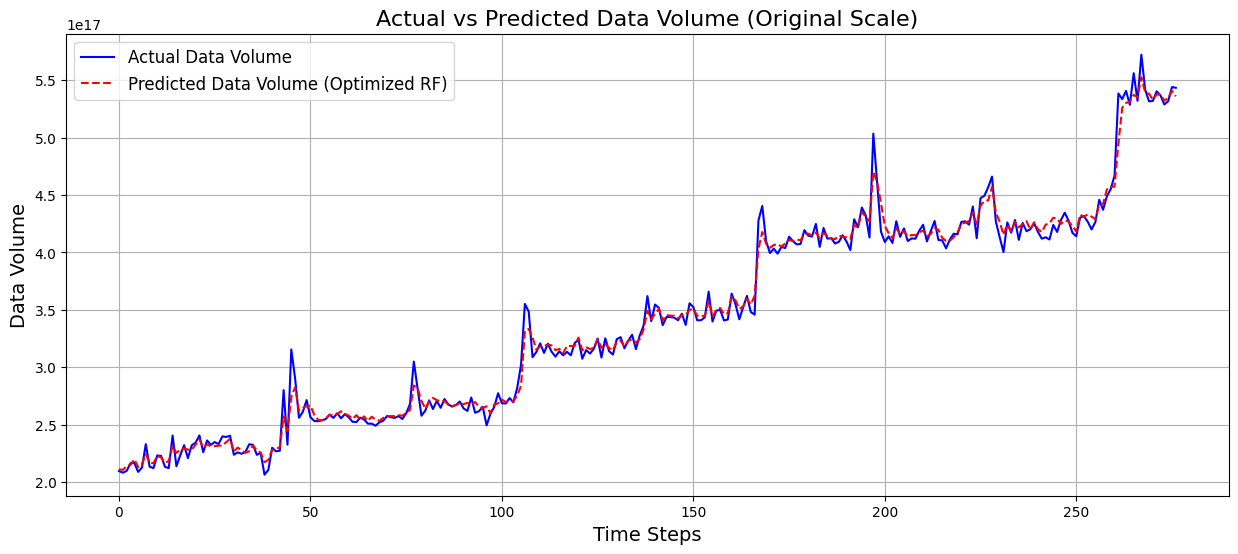

In [35]:
def inverse_transform_predictions(preds, target_scaler, feature_scaler):
    """
    Convert normalized predictions back to original scale using the target_scaler
    and create a dummy array with feature_scaler for inverse transformation of features.
    """
    preds_2d = preds.reshape(-1, 1)

    # Create a dummy array with the same number of features as the feature_scaler expects
    # and fill it with zeros, except for the target column.
    dummy = np.zeros((len(preds_2d), len(feature_scaler.feature_names_in_)))

    # Find the index of the target column in the feature names
    # This assumes the target column was also included in the features during feature scaling,
    # which is the case based on the notebook's scaling logic in cell EN8LQ-xTFJAD.
    target_col_name = 'data_volume' # Original target column name
    try:
        target_idx = list(feature_scaler.feature_names_in_).index(target_col_name)
    except ValueError:
        print(f"Warning: Target column '{target_col_name}' not found in feature_scaler's feature names. Using index 0 for dummy array.")
        target_idx = 0 # Fallback

    # Place the predictions (which are scaled target values) into the correct column in the dummy array
    dummy[:, target_idx] = target_scaler.inverse_transform(preds_2d).flatten()


    # Inverse transform the dummy array
    original_scale = feature_scaler.inverse_transform(dummy)

    # Extract the inverse transformed target column
    original_target_values = original_scale[:, target_idx]

    return original_target_values


# Define the target column name used during scaling
target_column_name = 'data_volume_scaled' # As defined in cell EN8LQ-xTFJAD

# Get actual data volume in original scale
actual_volume = inverse_transform_predictions(y_test, target_scaler, feature_scaler)

# Get predicted data volume in original scale from Optimized Random Forest
optimized_rf_volume_pred = inverse_transform_predictions(optimized_rf_pred, target_scaler, feature_scaler)

# Plot actual vs predicted data volume
plt.figure(figsize=(15, 6))
plt.plot(actual_volume, label='Actual Data Volume', color='blue')
plt.plot(optimized_rf_volume_pred, label='Predicted Data Volume (Optimized RF)', color='red', linestyle='--')

plt.title('Actual vs Predicted Data Volume (Original Scale)', fontsize=16)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Data Volume', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

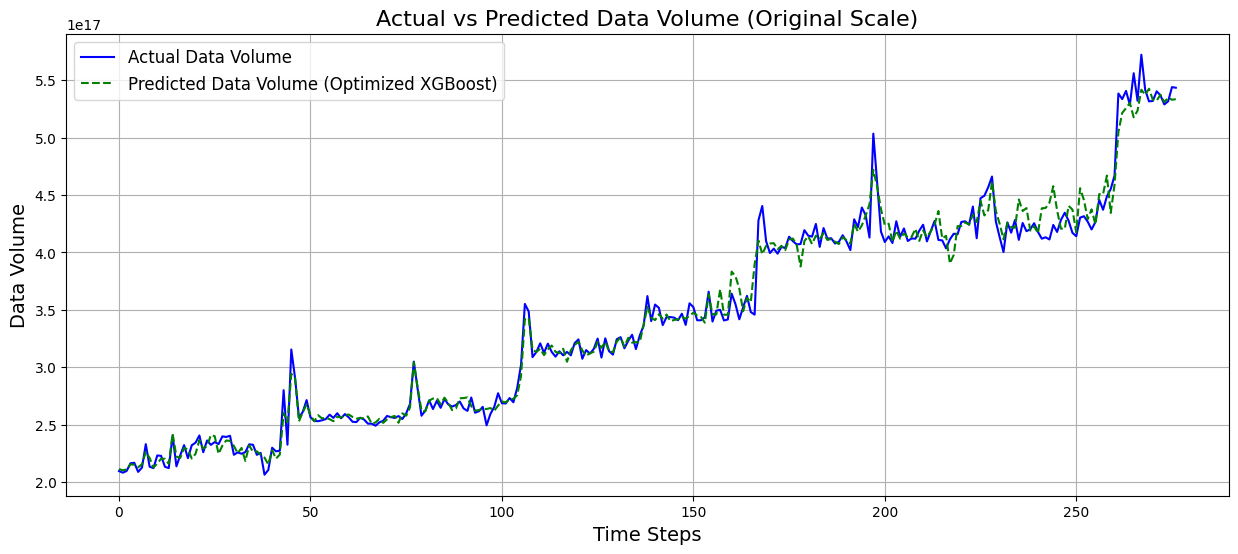

In [36]:
# Get predicted data volume in original scale from Optimized XGBoost
optimized_xgb_pred = optimized_xgb.predict(xgb_X_test)

# Inverse transform optimized XGBoost predictions
optimized_xgb_volume_pred = inverse_transform_predictions(
    optimized_xgb_pred,              # this is the optimized XGBoost predictions
    target_scaler,
    feature_scaler
)

# Plot actual vs predicted data volume (Optimized XGBoost)
plt.figure(figsize=(15, 6))
plt.plot(actual_volume, label='Actual Data Volume', color='blue')
plt.plot(optimized_xgb_volume_pred, label='Predicted Data Volume (Optimized XGBoost)', color='green', linestyle='--')

plt.title('Actual vs Predicted Data Volume (Original Scale)', fontsize=16)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Data Volume', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()